In [1]:
# conda env - /data/salomonis2/LabFiles/Frank-Li/scTriangulate/spatial_slide/sctri_spatial_env

In [2]:
import os
import sys
import random
import scanpy as sc
import anndata as ad
import pandas as pd
import anndata as ad
import matplotlib.pyplot as pltx
sys.path.insert(0,'/data/salomonis2/software')
from sctriangulate import ScTriangulate
from sctriangulate.colors import *
from sctriangulate.preprocessing import *
from sctriangulate.spatial import *

/users/asanb3/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---------------------------
# Set Random Seed
# ---------------------------
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
# ---------------------------
# Load metadata and expression
# ---------------------------
obs_df = pd.read_csv(
    "/data/salomonis2/LabFiles/Shunya_Asanuma/Spatial/LungChat/Output/Comparison/GSM8509590_GSE250346/Alignment/combined_metadata.csv",
    index_col="Xenium_ID"
)
expr_df = pd.read_csv(
    "/data/salomonis2/LabFiles/Shunya_Asanuma/Spatial/LungChat/Output/Comparison/GSM8509590_GSE250346/Alignment/combined_matrix.csv",
    index_col=0
)

# Assign rownames to match
assert expr_df.shape[0] == obs_df.shape[0], "Mismatch in number of spots"
expr_df.index = obs_df.index


In [5]:
# ---------------------------
# Create AnnData object
# ---------------------------
import anndata as ad
adata = ad.AnnData(X=expr_df.values, obs=obs_df)
adata.var_names = expr_df.columns
adata.obs_names = expr_df.index


In [6]:
# ---------------------------
# Add spatial coordinates
# ---------------------------
adata.obsm["X_spatial_xenium"] = obs_df[["X_xenium_norm", "Y_xenium_norm"]].values
adata.obsm["X_spatial_visium"] = obs_df[["X_visium_norm", "Y_visium_norm"]].values

In [7]:
# ---------------------------
# RNA Modality Clustering
# ---------------------------
adata_rna = scanpy_recipe(
    adata,
    species='human',
    is_log=False,
    resolutions=[0.0015, 0.002, 0.0022],
    modality='rna',
    pca_n_comps=50,
    n_top_genes=3000
)

# List all clustering columns generated
cluster_cols = [col for col in adata_rna.obs.columns if col.startswith("sctri_rna_leiden_")]
print("Clustering columns:", cluster_cols)

# Count unique clusters in each resolution
for col in cluster_cols:
    n_clusters = adata_rna.obs[col].nunique()
    print(f"{col}: {n_clusters} clusters")

/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Visium_ID' as categorical
/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute 

Clustering columns: ['sctri_rna_leiden_0.0015', 'sctri_rna_leiden_0.002', 'sctri_rna_leiden_0.0022']
sctri_rna_leiden_0.0015: 11 clusters
sctri_rna_leiden_0.002: 12 clusters
sctri_rna_leiden_0.0022: 13 clusters


In [8]:
# ---------------------------
# Spatial Modality Preparation
# ---------------------------

# Assign spatial coordinates (required by Squidpy & scTriangulate)
adata.obsm["spatial"] = adata.obsm["X_spatial_xenium"]

# Create spatial features (coordinate mode) — this computes spatial neighbor graph
from sctriangulate.spatial import create_spatial_features
adata_spatial = create_spatial_features(adata, mode='coordinate')

# Copy relevant metadata columns into the spatial AnnData
meta_cols = [
    "CNiche", "TNiche", "Final_CT", "Disease_status",
    "Sample_type", "Sample_affect",
    "Visium_RCTD_LungMap_ref", "Visium_RCTD_GSE250346_based",
    "Xenium_RCTD_LungMap_ref"
]
adata_spatial.obs[meta_cols] = adata.obs[meta_cols].copy()


In [9]:
# Run spatial clustering
adata_spatial = scanpy_recipe(
    adata_spatial,
    species='human',
    is_log=False,
    resolutions=[0.097, 0.099, 0.1],
    modality='spatial'
)

# Get spatial clustering columns
spatial_cluster_cols = [col for col in adata_spatial.obs.columns if col.startswith("sctri_spatial_leiden_")]

# Print number of clusters per resolution
for col in spatial_cluster_cols:
    n_clusters = adata_spatial.obs[col].nunique()
    print(f"{col}: {n_clusters} clusters")

/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CNiche' as categorical
/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'TNiche' as categorical
/users/asanb3/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories wil

sctri_spatial_leiden_0.097: 11 clusters
sctri_spatial_leiden_0.099: 12 clusters
sctri_spatial_leiden_0.1: 13 clusters


In [10]:
# Assign UMAP based on Xenium spatial layout
adata_spatial.obsm["X_umap"] = adata.obsm["X_spatial_xenium"]


In [11]:
# ---------------------------
# Concatenate RNA and Spatial Modalities
# ---------------------------
adata_merge = concat_rna_and_other(
    adata_rna,
    adata_spatial,
    umap='other',
    umap_key='X_umap',
    name='spatial',
    prefix=''
)

In [12]:
# ---------------------------
# Run scTriangulate
# ---------------------------
sctri = ScTriangulate(
    # dir='/data/salomonis2/LabFiles/Shunya_Asanuma/Spatial/LungChat/Output/Comparison/GSM8509590_GSE250346/scTriangulate/GSM8509590_GSE250346/output_xenium_visium_V10',
    adata=adata_merge,
    query=[
        'sctri_rna_leiden_0.0015',
        'sctri_rna_leiden_0.002',
        'sctri_rna_leiden_0.0022',
        'sctri_spatial_leiden_0.097',
        'sctri_spatial_leiden_0.099',
        'sctri_spatial_leiden_0.1',
        'Final_CT',
        'Visium_RCTD_LungMap_ref',
        'Visium_RCTD_GSE250346_based',
        'Xenium_RCTD_LungMap_ref',
        'CNiche',
        'TNiche'
    ]
)


2025-06-09 21:23:12,818 - INFO - Choosing logging to console (VERBOSE=1)
2025-06-09 21:23:12,818 - INFO - Choosing logging to console (VERBOSE=1)
2025-06-09 21:23:13,075 - INFO - skip scrublet doublet prediction, instead doublet is filled using value 0.5
2025-06-09 21:23:13,075 - INFO - skip scrublet doublet prediction, instead doublet is filled using value 0.5


In [15]:
sctri.lazy_run(
    scale_sccaf=False,
    viewer_heterogeneity=True,
    viewer_heterogeneity_keys=['Final_CT'],  # or any annotation key you want
    viewer_cluster=True,
    viewer_cluster_keys=['Final_CT']
)


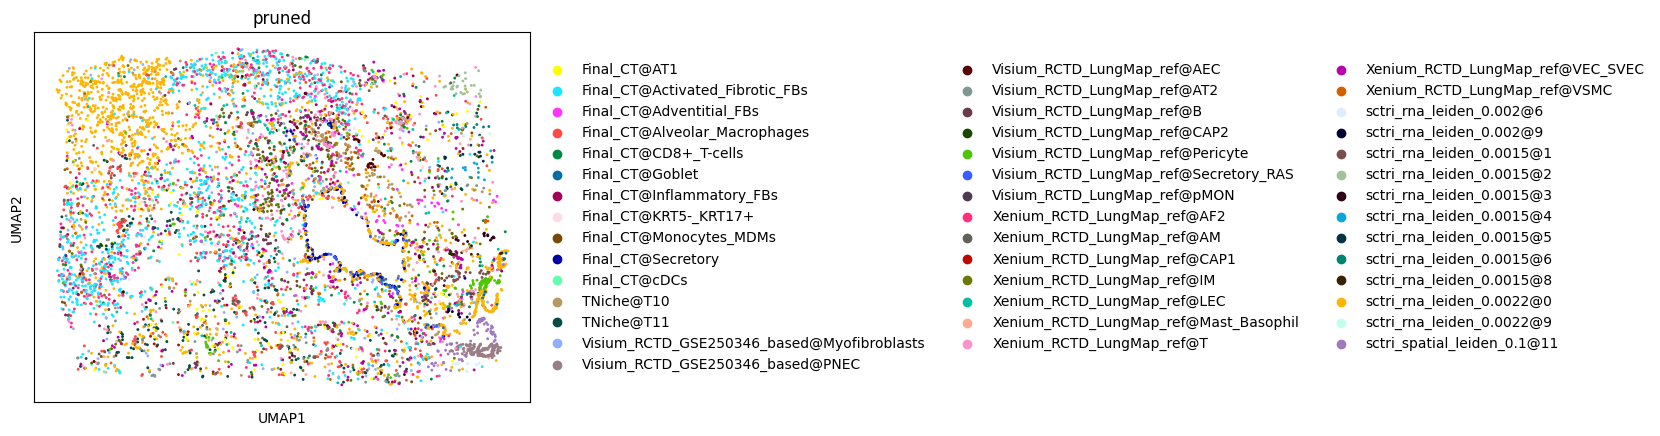

In [14]:
sc.pl.umap(
    adata_merge,
    color=[
        'pruned'],
    ncols=1
)
